<a href="https://colab.research.google.com/github/cchen744/CornYield_NN/blob/geo/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Spatial analysis for Wisconsin corn yield
- Moran's I for spatial autocorrelation
- Geographical Weighted Regression (GWR)



In [38]:
import pandas as pd
import geopandas as gpd
from esda.moran import Moran,Moran_Local
from libpysal.weights import Queen
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

## 1. clone github repository

In [3]:
# Access github repo
REPO_URL = "https://github.com/cchen744/CornYield_NN.git"
REPO_NAME = "CornYield_NN" # This is the folder name that will be created

# 4. Clone the repository
# We use the token for secure, authenticated access
!git clone https://github.com/cchen744/CornYield_NN.git

# 5. Change the working directory into the cloned repository folder
import os
os.chdir(REPO_NAME)

# Verify the files are there (you should see your notebook and dataset files)
print(f"Current directory contents in /{REPO_NAME}:")
!ls -F

Cloning into 'CornYield_NN'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 78 (delta 36), reused 31 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 3.64 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Current directory contents in /CornYield_NN:
counties.csv		     prism_weather_1995-2009.csv  weather_clean.csv
final_dataset.csv	     prism_weather_2010-2024.csv  wide_data.csv
get_data.ipynb		     prism_weather.csv		  yield_clean.csv
LSTM_+_MLP_model.ipynb	     RandomForest.ipynb		  yield.csv
nasa_weather.csv	     soil_clean.csv
prism_weather_1984-1994.csv  soil_data.csv


## 2. Data Exploration



*   Load yield data
*   Check dataset information



In [4]:
# Load yield data
df =  pd.read_csv("/content/CornYield_NN/yield_clean.csv")

# Check dataset information
# check first 5 rows
print("First 5 rows:")
print(df.head())

# check column names
print("Column names:")
print(df.columns)

# check dataset shape
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# check number of unique counties

print(f"Number of unique counties: {df['County'].nunique()}")

# check year range
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}")

# check completeness
expected_rows =  df['County'].nunique() * (df['Year'].max() - df['Year'].min() + 1)
actual_rows = 2603

print(f"Expected rows: {expected_rows}")
print(f"Actual rows: {actual_rows}")
print(f"* Missing rows: {expected_rows - actual_rows}")

First 5 rows:
   Year      County  Yield
0  2024       adams  120.1
1  2024  green lake  168.3
2  2024      juneau  141.0
3  2024   marquette  126.0
4  2024     portage  159.5
Column names:
Index(['Year', 'County', 'Yield'], dtype='object')
Total rows: 2603
Total columns: 3
Number of unique counties: 71
Year range: 1984 to 2024
Expected rows: 2911
Actual rows: 2603
* Missing rows: 308


- dataset aggregation (for Moran's I) through averaging multiple yearly yield: We collapse the temporal dimension to focus on the long-term spatial structure

In [5]:
# Step 1: grouby county
avg_yield_df = df.groupby('County')['Yield'].mean(). \
               reset_index()

# Step 2: rename 'county' column
avg_yield_df.columns = ['County', 'AverageYield']

# Step 3: check the result
print("\n")
print("Average Yield by County:")
print(avg_yield_df.head(10))

# Step 4: show stats
print("\n")
print("Statistics of Average Yield:")
print(avg_yield_df['AverageYield'].describe())



Average Yield by County:
     County  AverageYield
0     adams    116.338462
1   ashland     89.847059
2    barron    122.973171
3  bayfield     97.473333
4     brown    128.264865
5   buffalo    140.680488
6   burnett    105.004878
7   calumet    136.015385
8  chippewa    126.470732
9     clark    120.270000


Statistics of Average Yield:
count     71.000000
mean     125.981453
std       19.494987
min       76.183333
25%      114.679231
50%      131.612195
75%      138.404597
max      158.470732
Name: AverageYield, dtype: float64


- load GeoJSON for Moran's I and GWR

In [6]:
wi_gdf = gpd.read_file("https://raw.githubusercontent.com/mhaffner/data/master/wi_counties.geojson")
print(wi_gdf.columns)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [7]:
# county name alignment
## County column name is different in average yield dataset and geojson file, so we need to both lowercase them to make an alignment
### inspect county names in spatial data
print("Sample county names from spatial data:")
print(wi_gdf['NAME'].head())

### inspect county names in yield data
print("Sample county names from yield data:")
print(avg_yield_df['County'].head())

# create standardized county name for merging
wi_gdf['county_std'] = wi_gdf['NAME'].str.lower()
avg_yield_df['county_std'] = avg_yield_df['County'].str.lower()

print("\nSpatial counties:", wi_gdf['county_std'].nunique())
print("Yield counties:", avg_yield_df['county_std'].nunique())


print("Spatial counties (std):")
print(sorted(wi_gdf['county_std'].unique())[:10])

print("\nYield counties (std):")
print(sorted(avg_yield_df['county_std'].unique())[:10])



Sample county names from spatial data:
0    Trempealeau
1           Sauk
2          Grant
3      Marinette
4        Ashland
Name: NAME, dtype: object
Sample county names from yield data:
0       adams
1     ashland
2      barron
3    bayfield
4       brown
Name: County, dtype: object

Spatial counties: 72
Yield counties: 71
Spatial counties (std):
['adams', 'ashland', 'barron', 'bayfield', 'brown', 'buffalo', 'burnett', 'calumet', 'chippewa', 'clark']

Yield counties (std):
['adams', 'ashland', 'barron', 'bayfield', 'brown', 'buffalo', 'burnett', 'calumet', 'chippewa', 'clark']


Now, there is a discrepancy in spatial counties (72 counties in total) and yield counties (71 counties in total). We need to find out which county is missing in yield counties by merging two datasets.

In [8]:
# Merge Spatial + Yield

merged_gdf = wi_gdf.merge(
    avg_yield_df[['county_std', 'AverageYield']],
    on='county_std',
    how='left'
)

print("Merged GeoDataFrame:")
print(merged_gdf.head())

# Check missing yield after merge
missing = merged_gdf[merged_gdf['AverageYield'].isna()]

print("Counties with missing yield data:")
print(missing[['NAME', 'county_std']])
print(f"\nNumber of missing counties: {len(missing)}")



Merged GeoDataFrame:
  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID         NAME LSAD  \
0      55      121  01581120  0500000US55121  55121  Trempealeau   06   
1      55      111  01581115  0500000US55111  55111         Sauk   06   
2      55      043  01581081  0500000US55043  55043        Grant   06   
3      55      075  01581097  0500000US55075  55075    Marinette   06   
4      55      003  01581061  0500000US55003  55003      Ashland   06   

          ALAND        AWATER  \
0  1.898473e+09  2.337105e+07   
1  2.153686e+09  4.569300e+07   
2  2.970402e+09  9.452162e+07   
3  3.624599e+09  3.898766e+08   
4  2.706476e+09  3.230711e+09   

                                            geometry   county_std  \
0  MULTIPOLYGON (((-91.61285 44.1735, -91.61174 4...  trempealeau   
1  MULTIPOLYGON (((-90.3124 43.64099, -90.3023 43...         sauk   
2  MULTIPOLYGON (((-91.15681 42.98817, -91.15302 ...        grant   
3  MULTIPOLYGON (((-87.50588 45.05966, -87.50575 ...    marinette

After harmonizing spatial and yield datasets, two counties (Menominee and St. Croix) were excluded due to missing yield records. This means, after spatial alignment, yield data were available for 70 out of 72 Wisconsin counties. We should drop these two spatial-only counties.

In [9]:
# drop missing yield data counties
moran_gdf = merged_gdf.dropna(subset=['AverageYield']).copy()
print(f"Counties used for Moran's I: {len(moran_gdf)}")
# check coordinate reference system
print("\nCRS information:")
print(moran_gdf.crs)

Counties used for Moran's I: 70

CRS information:
EPSG:4269


## 3. Moran's I

- calculate spatial weights first

note: Queen contiguity (https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html#queen-contiguity)

In [10]:
# Spatial Weights

# build Queen contiguity weights
w = Queen.from_dataframe(moran_gdf)

# basic diagnostics
print(f"Number of observations: {w.n}")
print(f"Number of neighbor links: {w.s0}")

# check neighbors for one county
sample_county = list(w.neighbors.keys())[0]
print("\nSample county index:", sample_county)
print("Neighbors' indices:", w.neighbors[sample_county])


Number of observations: 70
Number of neighbor links: 354.0

Sample county index: 0
Neighbors' indices: [11, 57, 19, 39]


/tmp/ipython-input-627360057.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(moran_gdf)


- now **Moran's I**

In [11]:
# Moran's I

# Step 1: extract variable
y = moran_gdf['AverageYield'].values

# Step 2: run Moran's I
moran = Moran(y, w)

# Step 3: print results
print(f"Moran's I: {moran.I:.4f}")
print(f"Expected I (random): {moran.EI:.4f}")
print(f"p-value (permutation): {moran.p_sim:.4f}")


Moran's I: 0.7577
Expected I (random): -0.0145
p-value (permutation): 0.0010


**Result from Moran'I analysis:** <br> Global Moran’s I reveals strong and statistically significant positive spatial autocorrelation in long-term average corn yield across Wisconsin counties (I = 0.758, p < 0.01), indicating pronounced spatial clustering.


For the next step, we are about to find out the high-yield cluster and low-yield cluster by **Local Moran’s I（LISA）**. Therefore we will have an idea of how to split dataset and put them into GWR.

## 4. Local Moran's I

In [12]:
# Local Moran's I (LISA)
# Local Moran's I
lisa = Moran_Local(y,w)

# add results back to GeoDataFrame
moran_gdf['lisa_I'] = lisa.Is
moran_gdf['lisa_p'] = lisa.p_sim
moran_gdf['lisa_q'] = lisa.q   # quadrant labels: 1–4

# significance mask: filtering out statisticallly significant lisa I
moran_gdf['lisa_sig'] = moran_gdf['lisa_p'] < 0.05

# summarize LISA clusters (only significant)
cluster_counts = (
    moran_gdf[moran_gdf['lisa_sig']]
    .groupby('lisa_q')
    .size()
)

print("Significant LISA cluster counts:")
print(cluster_counts)


Significant LISA cluster counts:
lisa_q
1    13
3    14
dtype: int64


| lisa.q | meaning   |                  
| ------ | --------- |
| 1      | High–High |
| 2      | Low–High  |
| 3      | Low–Low   |
| 4      | High–Low  |



<br>
From the result, it is statistically significant that there are 13 counties in high-hight yield district while 13 counties in low-low yield district. So we can identify the clustering using this insight, and move to the next step - Geographically weighted regression

## 5. GWR

Given the spatial auto-correlation analysis, we know that there is a patter in corn yield across wisconsin. Now a natural follow-up question would be - does each factor (temp/precip/soil...) influence each region in the same way? Our hypotheses would say: NO. <br>
Now we will start from analysing simple features of temp and precip.

**Model Structure**
---------------
For each county i located at spatial coordinates (u_i, v_i):

    Yield_i =
        beta_0(u_i, v_i)
      + beta_1(u_i, v_i) * Temp_i
      + beta_2(u_i, v_i) * Precip_i
      + error_i

Where:
- (u_i, v_i): centroid coordinates of county i
- Yield_i: long-term average corn yield
- Temp_i: long-term growing-season mean temperature
- Precip_i: long-term growing-season total precipitation
- beta_k(u_i, v_i): spatially varying regression coefficients

In [13]:
# County Centroids for GWR

# create centroid points (keep original polygons too)
moran_gdf['centroid'] = moran_gdf.geometry.centroid

# extract coordinates
moran_gdf['x'] = moran_gdf['centroid'].x
moran_gdf['y'] = moran_gdf['centroid'].y

# quick check
print(moran_gdf[['NAME', 'x', 'y']].head())

# Build coords and y

coords = np.column_stack((moran_gdf['x'].values, moran_gdf['y'].values))
y = moran_gdf['AverageYield'].values.reshape((-1, 1))

print("coords shape:", coords.shape)
print("y shape:", y.shape)



          NAME          x          y
0  Trempealeau -91.358458  44.303968
1         Sauk -89.948224  43.426666
2        Grant -90.706205  42.867479
3    Marinette -88.033424  45.383021
4      Ashland -90.677944  46.316083
coords shape: (70, 2)
y shape: (70, 1)


/tmp/ipython-input-2741493077.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  moran_gdf['centroid'] = moran_gdf.geometry.centroid


In [14]:
# Sanity checks

print("Any NaN in coords?", np.isnan(coords).any())
print("Any NaN in y?", np.isnan(y).any())

print("\ncoords ranges:")
print("x min/max:", coords[:, 0].min(), coords[:, 0].max())
print("y min/max:", coords[:, 1].min(), coords[:, 1].max())

print("\ny ranges:")
print("y min/max:", y.min(), y.max())


Any NaN in coords? False
Any NaN in y? False

coords ranges:
x min/max: -92.44135792588344 -87.31350124877433
y min/max: 42.57692417592539 46.523761618098575

y ranges:
y min/max: 76.18333333333334 158.47073170731707


- Now prepare for X dataframe

In [15]:
# Inspect Weather/Feature Data

weather_df_path = "/content/CornYield_NN/weather_clean.csv"
df_feat = pd.read_csv(weather_df_path)

print("First 5 rows:")
print(df_feat.head())

print("\nColumns:")
print(df_feat.columns)

print("\nRow count:", len(df_feat))

print("\nUnique counties:", df_feat['County'].nunique())
print("Year range:", df_feat['Year'].min(), "to", df_feat['Year'].max())


First 5 rows:
  County  Year  Month  solar_radiation  humidity  wind_speed  wind_speed_max  \
0  adams  1984      4            16.85     75.80        4.40           12.36   
1  adams  1984      5            17.63     74.25        3.26            9.64   
2  adams  1984      6            20.75     78.96        3.42            9.15   
3  adams  1984      7            21.90     74.48        2.68            8.19   
4  adams  1984      8            18.52     68.76        2.31            6.40   

   precip  temp_min  temp_mean  temp_max  dewpoint_mean  vpd_min  vpd_max  
0    3.83      35.5       46.5      57.5           29.7     1.57    10.85  
1    2.27      41.4       53.7      65.9           40.2     1.12    13.40  
2    5.96      56.2       68.1      80.0           57.0     1.20    18.43  
3    3.29      56.9       69.4      81.9           58.0     1.08    20.90  
4    2.54      58.5       70.9      83.2           60.5     0.85    20.17  

Columns:
Index(['County', 'Year', 'Month', 'sola

- precipitation aggregation
- temperature aggregation

In [16]:
# Aggregate to County-Year

county_year = (
    df_feat
    .groupby(['Year','County'])
    .agg(
        temp_mean = ('temp_mean','mean'),
        precip_sum = ('precip','sum')
    )
    .reset_index()
)

print("County-Year features:")
print(county_year.head())

# Multi-year County Averages

county_feat = (
    county_year
    .groupby('County')
    .agg(
        temp_mean = ('temp_mean','mean'),
        precip_mean = ('precip_sum','mean')
    )
    .reset_index()
)


print("County-level long-term climate features:")
print(county_feat.head())
print("\nSummary statistics:")
print(county_feat.describe())


County-Year features:
   Year    County  temp_mean  precip_sum
0  1984     adams  61.150000       22.63
1  1984   ashland  57.350000       22.86
2  1984    barron  60.333333       23.75
3  1984  bayfield  56.933333       26.47
4  1984     brown  59.733333       23.46
County-level long-term climate features:
     County  temp_mean  precip_mean
0     adams  61.361382    24.059024
1   ashland  57.376829    21.725854
2    barron  60.269512    22.504878
3  bayfield  57.241870    22.478049
4     brown  60.626423    20.121951

Summary statistics:
       temp_mean  precip_mean
count  72.000000    72.000000
mean   60.454613    23.050698
std     1.984976     1.804700
min    55.978862    18.040244
25%    58.981606    21.818110
50%    60.824593    23.047683
75%    62.019919    24.336463
max    63.347967    26.034146


In [21]:
# Merge Features for GWR

# standardize county name
county_feat['county_std'] = county_feat['County'].str.lower()

gwr_gdf = moran_gdf.merge(
    county_feat[['county_std','temp_mean','precip_mean']],
    on='county_std',
    how='left'
)


print("Merged GWR GeoDataFrame:")
print(gwr_gdf[['NAME','AverageYield','temp_mean','precip_mean']].head())

print("\nAny missing climate features?")
print(gwr_gdf[['temp_mean','precip_mean']].isna().sum())


Merged GWR GeoDataFrame:
          NAME  AverageYield  temp_mean  precip_mean
0  Trempealeau    135.229268  60.967480    25.355366
1         Sauk    138.365854  62.120325    26.034146
2        Grant    155.400000  62.694309    25.387073
3    Marinette    112.530769  58.621951    20.506829
4      Ashland     89.847059  57.376829    21.725854

Any missing climate features?
temp_mean      0
precip_mean    0
dtype: int64


Now we have finished the data cleaning for geographically weighted regression. The next step is normalization. This is an essential step as the bandwidth selection and local regression in GWR are highly sensitive to the scale of the variables.

In [22]:
# Standardize X (weather features)
scaler = StandardScaler()

X = gwr_gdf[['temp_mean','precip_mean']].values
X_std = scaler.fit_transform(X)

print("X shape:", X_std.shape)
print("Means (should be ~0):", X_std.mean(axis=0))
print("Stds (should be ~1):", X_std.std(axis=0))

y = gwr_gdf['AverageYield'].values.reshape((-1, 1))

print("y shape:", y.shape)



X shape: (70, 2)
Means (should be ~0): [-7.76997514e-15  2.06818689e-15]
Stds (should be ~1): [1. 1.]
y shape: (70, 1)


- Baseline: OLS


AIC is used for testing overfitting, the smaller the better. details:https://en.wikipedia.org/wiki/Akaike_information_criterion#:~:text=Suppose%20that%20we%20have,%5D%5B5%5D

In [25]:
# OLS Baseline

# add intercept
X_ols = sm.add_constant(X_std)

# fit OLS
ols_model = sm.OLS(y, X_ols).fit()

# print key results
print("OLS baseline results:")
print("R^2:", ols_model.rsquared)
print("AIC:", ols_model.aic)
print("Coefficients:", ols_model.params)
print("p-values:", ols_model.pvalues)



OLS baseline results:
R^2: 0.7705419605225593
AIC: 517.2074017249929
Coefficients: [125.85080479  17.01457317   0.13871803]
p-values: [1.51489779e-77 9.07057417e-20 9.16783758e-01]


R^2 = 0.771 : the linear model can already explain 77% of the spatial variability

Coefficients p- values:
- temp: A one standard deviation increase in growing-season mean temperature is associated with an average increase of approximately 17 units in corn yield with p-value of 9.07057417e-20 (statistically significant)
- precip: coefficient of precip is  0.14 with p-value of 0.9 (insignificant)

**Now, the question arises - does the influence from precipitation be averaged by global model? What if it is significant in some specific region?**


* Global Moran’s I: yield shows strong spatial clustering

* LISA : significant HH/LL clusters

OLS:
* Temperature is significant

* Precipitation is not significant globally

Now, test residual from OLS to see if the unexplained variation from OLS can be explained by GWR

In [26]:
# Moran's I on OLS residuals
resid = ols_model.resid

moran_resid = Moran(resid, w)

print("Moran's I on OLS residuals:")
print(f"I: {moran_resid.I:.4f}")
print(f"p-value: {moran_resid.p_sim:.4f}")


Moran's I on OLS residuals:
I: 0.1629
p-value: 0.0150


I = 0.163, p = 0.015 → Significant spatial structure persists after the global model

After testifying the legitemacy of using GWR by Moran's I, Local Moran's I, as well as OLS's residual, we now can dive formally into GWR

In [29]:
# GWR Bandwidth Selection

# bandwidth selector
bw_selector = Sel_BW(
    coords,
    y,
    X_std,
    spherical=False
)

# search optimal bandwidth
bw = bw_selector.search()

print("Optimal GWR bandwidth:", bw)

# Fit GWR

gwr_model = GWR(
    coords,
    y,
    X_std,
    bw,
    spherical=False
)

gwr_results = gwr_model.fit()

print("GWR Results:")
print("GWR R^2:", gwr_results.R2)
print("GWR AIC:", gwr_results.aic)



Optimal GWR bandwidth: 47.0
GWR Results:
GWR R^2: 0.8453887012087937
GWR AIC: 501.483532207557


**OLS Results:**

R^2: 0.7705419605225593

AIC: 517.2074017249929

**GWR Results:**

GWR R^2: 0.8453887012087937

GWR AIC: 501.483532207557

*GWR explains the variation in corn yield better than OLS does. Meanwhile, it has smaller AIC, indicating that even we used a more commplicated model (GWR),it is worthwhile because the improvement of explanatory power overpasses the cost complexity.*

- explain GWR results - how coefficients perform differently in different regions?

In [36]:
# Extract Local Coefficients

gwr_gdf['beta_intercept'] = gwr_results.params[:, 0]
gwr_gdf['beta_temp']      = gwr_results.params[:, 1]
gwr_gdf['beta_precip']    = gwr_results.params[:, 2]


print(gwr_gdf[['NAME','beta_temp','beta_precip']].head())

# temp coef summary
print("\nTemperature coefficient summary:")
print(gwr_gdf['beta_temp'].describe())

# precip coef summary
print("\nPrecipitation coefficient summary:")
print(gwr_gdf['beta_precip'].describe())

          NAME  beta_temp  beta_precip
0  Trempealeau  12.498775     6.971459
1         Sauk  14.824970     3.126658
2        Grant  15.381433     4.822333
3    Marinette  18.271798    -4.565260
4      Ashland  15.615061     7.398166

Temperature coefficient summary:
count    70.000000
mean     13.384873
std       3.056546
min       6.555345
25%      11.836793
50%      13.905388
75%      15.252521
max      19.407859
Name: beta_temp, dtype: float64

Precipitation coefficient summary:
count    70.000000
mean      2.790417
std       4.048520
min      -4.565260
25%      -0.210279
50%       2.114153
75%       6.964600
max       8.661029
Name: beta_precip, dtype: float64


## Explanation of the GWR summary

- **Temperature** coefficients range from 6.56 to 19.4 across Wisconsin, indicating that growing-season temperature is positively associated with corn yield in all counties. However, the magnitude of this effect varies substantially across space, with nearly a threefold difference between the weakest and strongest local relationships.

- In contrast, **precipitation** coefficients range from −4.57 to 8.66, suggesting that precipitation influences corn yield in different directions across counties. While precipitation is positively associated with yield in some regions, it exhibits neutral or negative effects in others. This pronounced spatial heterogeneity is **averaged out in the global OLS model**, resulting in a non-significant overall precipitation effect.

### Visualization of GWR result
How coefficients spread over Wisconsin?

In [37]:
print(gwr_gdf[['NAME','beta_temp','beta_precip']].describe())

       beta_temp  beta_precip
count  70.000000    70.000000
mean   13.384873     2.790417
std     3.056546     4.048520
min     6.555345    -4.565260
25%    11.836793    -0.210279
50%    13.905388     2.114153
75%    15.252521     6.964600
max    19.407859     8.661029


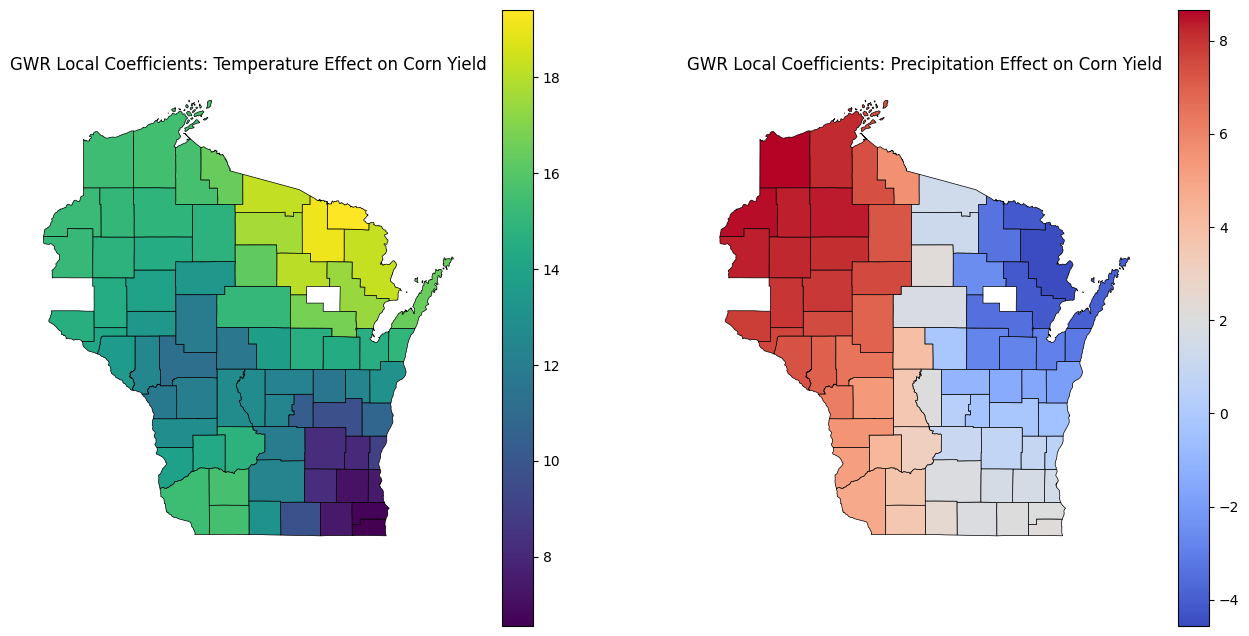

In [52]:
# Plot Temperature Coefficients
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

gwr_gdf.plot(
    column='beta_temp',
    cmap='viridis',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax[0]
)

# Plot Precipitation Coefficients

gwr_gdf.plot(
    column='beta_precip',
    cmap='coolwarm',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax[1]
)

ax[1].set_title('GWR Local Coefficients: Precipitation Effect on Corn Yield')
ax[1].axis('off')


ax[0].set_title('GWR Local Coefficients: Temperature Effect on Corn Yield')
ax[0].axis('off')

plt.show()


## RESULT AND DISCUSSION
These results reveal clear spatial heterogeneity in the effects of climate variables on corn yield across Wisconsin.

Temperature.
The effect of temperature on corn yield exhibits a clear clustered spatial pattern across the state. As shown in the map, temperature has the strongest influence in southeastern Wisconsin, while the weakest effects are observed in the northeastern region. Counties in central Wisconsin display intermediate coefficient values, forming a smooth spatial gradient characterized by a general decrease in temperature sensitivity from south to north.

Precipitation.
In contrast to temperature, the effect of precipitation demonstrates a distinct east–west spatial pattern. Precipitation coefficients generally decrease from eastern to western Wisconsin, indicating substantial regional variation in both the magnitude and direction of precipitation–yield relationships.

**These spatially varying relationships help explain the strong spatial clustering observed in corn yield and highlight the limitations of global models that assume spatial stationarity.**